# CSC413 Project: GeoGuessr!


## A bunch of imports

In [1]:
from typing import *
from collections import defaultdict
from PIL import Image
from IPython.display import display
from glob import glob
import re
import os
from random import shuffle
import time
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import xml.etree.ElementTree as ET
import numpy as np
 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms, models
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=6fe62db048060cbf89af1c6d3434b7b8910f28cce63897f0ed16ddc478ab7482
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


## Visualizing stuff

In [2]:
# Reverse normalization
torch.manual_seed(0)
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def visualize_example(tup, batch_idx=0, invert=False):
  bs, n, c, height, width = tup.shape
  dst = Image.new("RGB", (4*width, height))
  tup = tuple(tup[batch_idx, i] for i in range(4))

  if invert: 
    tup = tuple(inv_normalize(t) for t in tup)
  dst.paste(transforms.ToPILImage()(tup[0]), (0, 0))
  dst.paste(transforms.ToPILImage()(tup[1]), (width, 0))
  dst.paste(transforms.ToPILImage()(tup[2]), (width*2, 0))
  dst.paste(transforms.ToPILImage()(tup[3]), (width*3, 0))
  display(dst)


def get_borders(states_file):
    """ From original DeepGeo paper """
    #init
    borders = []

    # get state borders  
    tree = ET.parse(states_file)
    root = tree.getroot()
    count = 0
    for child in root:
        count+=1
        stateBorder = np.empty((0,2),dtype=np.float64)
        for point in child:
            stateBorder = np.append(stateBorder,np.array([[point.attrib['lng'], point.attrib['lat']]]),axis=0)
        borders.append(stateBorder)

    return borders

def get_labels(states_file):
    """ From original DeepGeo paper """
    labels = []

    # get state borders  
    tree = ET.parse(states_file)
    root = tree.getroot()
    count = 0
    for child in root:
        labels.append(child.attrib['name'])

    return labels

def plot_data_samples():
    coords = []
    for d in glob("training/*"):
      with open(f"{d}/info.txt", "r") as f:
        coords.extend([l.split(" ")[-3:-1] for l in f.readlines() if not l.startswith("/mnt") and not l.startswith("//mnt")])
    coords = [coord for coord in coords if len(coord)==2 and coord[0] and coord[1]]
    borders = get_borders("Canada.kml")
    labels = get_labels("Canada.kml")
    
    bord_arr = np.concatenate(borders).astype(float)
    fig, ax = plt.subplots()
    lines = LineCollection([bord_arr])
    ax.add_collection(lines)
    coords_arr = np.array(coords).astype(float)
    ax.scatter(coords_arr[:,1], coords_arr[:,0], s=1)
    ax.autoscale()
    plt.show()
    

## Load in the data

In [3]:
# 1k Canada dataset
!gdown --id 1RQHBfuojV_gv7cFO38AXXPOG34cYyGeK

# Min 3.5k Canada dataset
# !gdown --id 1JjbMa-n_jb0X60KNk4h12ePjynTwMgwO

# Canadian provinces
!gdown --id 1SMxaLVYSDKS3AT3T8f_BgkWYBzWnrCqM
!mkdir training

Downloading...
From: https://drive.google.com/uc?id=1RQHBfuojV_gv7cFO38AXXPOG34cYyGeK
To: /content/1kimages090180270.tar.gz
420MB [00:03, 135MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SMxaLVYSDKS3AT3T8f_BgkWYBzWnrCqM
To: /content/Canada.kml
100% 38.3k/38.3k [00:00<00:00, 23.7MB/s]


In [4]:
%%capture
!tar -xzvf 1kimages090180270.tar.gz -C training
# !tar -xzvf min3kimages.tar.gz -C training
!for d in training/images*; do mv "${d}" "training/`basename "${d}" | sed -e 's/images//g' | sed -e 's/\s//g'`"; done
!rm -rf 1kimages090180270.tar.gz
# !rm -rf min3kimages.tar.gz

In [5]:
data = defaultdict(list)

def get_image_ids(province: str) -> List[str]:
  images = glob(f"training/{province}/*.jpg")
  ids_no_angle = [re.sub('_[\\d]*.jpg', '', f) for f in images]
  return ids_no_angle 

def stitch_images_and_save(image_base_path: str) -> None:
  img = Image.new("RGB", (512, 512))
  img_0 = Image.open(f"{image_base_path}_0.jpg")
  img_90 = Image.open(f"{image_base_path}_90.jpg")
  img_180 = Image.open(f"{image_base_path}_180.jpg")
  img_270 = Image.open(f"{image_base_path}_270.jpg")
  img.paste(img_0, (0, 0))
  img.paste(img_90, (256, 0))
  img.paste(img_180, (0, 256))
  img.paste(img_270, (256, 256))

  new_name = f"{image_base_path}_stitched.jpg"
  img.save(new_name)
  data[image_base_path.split("/")[-2]].append(new_name)

## A custom dataset

In [6]:
preprocess =  transforms.Compose([
                    transforms.Resize(284),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])
class GeoDataset(Dataset):
  """
  Holds a bunch of (N, E, S, W) quadruplets of examples along with the corresponding province labels.

  # Todo: maybe add transform?
  """
  def __init__(self, index_file, transform=None, shuf=False):
    self.index_file = index_file
    self.transform = transform

    self.labels = {k: i for i, k in enumerate(index_file.keys())}

    # Data has (N, E, S, W, province)
    self.data = []
    for prov, tups in index_file.items():
      for tup in tups:
        self.data.append((*tup, prov))
    if shuf:
      shuffle(self.data)

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, idx):
    """
    Returns: 
      (N, E, S, W) images, province
    tuple
    """
    tup = self.data[idx]
    images = torch.cat(tuple(preprocess(Image.open(t)).unsqueeze(0) for t in tup[:-1]), 0) 
    return (images, self.labels[tup[-1]])


In [7]:
index_files = defaultdict(list)

for province in glob("training/*"):
  name = os.path.basename(province)
  for image in get_image_ids(name):
    # stitch_images_and_save(image)
    index_files[name].append(tuple(f"{image}_{angle}.jpg" for angle in ("0", "90", "180", "270")))

In [8]:
dataset = GeoDataset(index_files)
length = len(dataset)

train_frac = 0.8
val_frac = test_frac = 0.1
train_len = int(train_frac*length)
val_len = test_len = int(val_frac*length)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_len, val_len, test_len])

#train_set = torch.utils.data.Subset(dataset, list(range(0, int(train_frac*length))))
#val_set = torch.utils.data.Subset(dataset, list(range(len(train_set), len(train_set)+int(val_frac*length)+1)))
#test_set = torch.utils.data.Subset(dataset, list(range(len(train_set)+len(val_set), len(train_set)+len(val_set) + int(test_frac*length)+1)))
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2, prefetch_factor=8)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=2, prefetch_factor=8)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=2, prefetch_factor=8)

In [9]:
images, labels = next(iter(test_loader))

# What the data looks like
We have in the top image the unnormalized image. 

The image below that is the same image, but with normalization as a preprocessing step before adding it to the model.

The third image contains a scatterplot of where street view data samples were collected across Canada. Because most upper parts of Canada are sparsely populated, not much data was collected; the Thunder Bay area in Ontario, for example, is one of the northmost areas that have data...most of the data in Ontario is in the GTA region.

Note: the map looks very crude to simplify the data collection and classification process because it didn't really matter how fine the details were on the borders since street view doesn't gather images right by the oceanside.

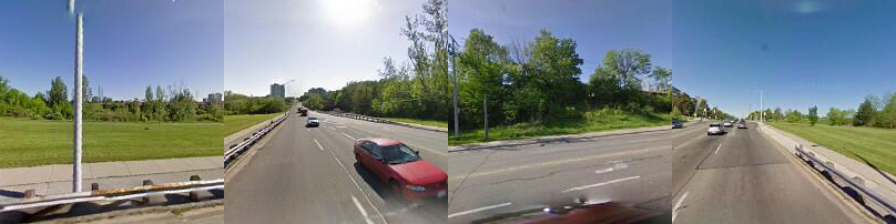

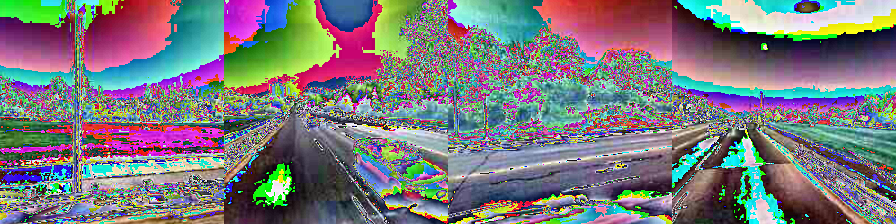

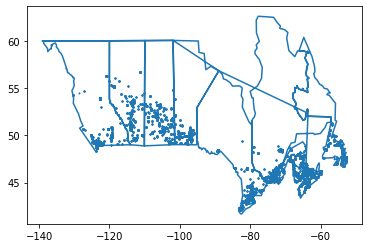

In [10]:
visualize_example(images, 10, True)
visualize_example(images, 10, False)
plot_data_samples()

## Code to actually do the training logic

## EfficientNet

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = EfficientNet.from_pretrained('efficientnet-b0')
for param in model.parameters():
    param.requires_grad = False
    
model._fc = nn.Sequential(nn.Linear(1280, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model._fc.parameters(), lr=0.003)
model.to(device)

epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses, accs = [], [], []

model.eval()
for epoch in range(epochs):
      for i, data in enumerate(train_loader):
          inputs, labels = data
          steps += 1
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()

          n_logps = model.forward(inputs[:,0,...])
          n_loss = criterion(n_logps, labels)
          n_loss.backward()

          e_logps = model.forward(inputs[:,1,...])
          e_loss = criterion(e_logps, labels)
          e_loss.backward()

          s_logps = model.forward(inputs[:,2,...])
          s_loss = criterion(s_logps, labels)
          s_loss.backward()

          w_logps = model.forward(inputs[:,3,...])
          w_loss = criterion(w_logps, labels)
          w_loss.backward()

          loss = n_loss + e_loss + s_loss + w_loss

          optimizer.step()
          running_loss += loss.item()
          
          if steps % print_every == 0:
              test_loss = 0
              accuracy = 0
              model.eval()
              with torch.no_grad():
                  for inputs, labels in test_loader:
                      inputs, labels = inputs.to(device), labels.to(device)

                      n_logps = model.forward(inputs[:,0,...])
                      n_batch_loss = criterion(n_logps, labels)
                      test_loss += n_batch_loss.item()

                      e_logps = model.forward(inputs[:,1,...])
                      e_batch_loss = criterion(e_logps, labels)
                      test_loss += e_batch_loss.item()

                      s_logps = model.forward(inputs[:,2,...])
                      s_batch_loss = criterion(s_logps, labels)
                      test_loss += s_batch_loss.item()

                      w_logps = model.forward(inputs[:,3,...])
                      w_batch_loss = criterion(w_logps, labels)
                      test_loss += w_batch_loss.item()

                      logps = (n_logps + e_logps + s_logps + w_logps)/4
                      
                      ps = torch.exp(logps)
                      top_p, top_class = ps.topk(1, dim=1)
                      equals = top_class == labels.view(*top_class.shape)
                      accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
              train_losses.append(running_loss/len(train_loader))
              test_losses.append(test_loss/len(test_loader))     
              accs.append(accuracy/len(test_loader))               
              print(f"Epoch {epoch+1}/{epochs}.. "
                    f"Train loss: {running_loss/print_every:.3f}.. "
                    f"Test loss: {test_loss/len(test_loader):.3f}.. "
                    f"Test accuracy: {accuracy/len(test_loader):.3f}")
              
              running_loss = 0
              model.train()
            

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0
Epoch 1/1.. Train loss: 9.094.. Test loss: 8.586.. Test accuracy: 0.210
Epoch 1/1.. Train loss: 9.067.. Test loss: 8.740.. Test accuracy: 0.191
Epoch 1/1.. Train loss: 8.567.. Test loss: 8.662.. Test accuracy: 0.211
Epoch 1/1.. Train loss: 8.553.. Test loss: 8.239.. Test accuracy: 0.268
Epoch 1/1.. Train loss: 8.011.. Test loss: 8.008.. Test accuracy: 0.294
Epoch 1/1.. Train loss: 7.996.. Test loss: 7.756.. Test accuracy: 0.368
Epoch 1/1.. Train loss: 7.895.. Test loss: 7.863.. Test accuracy: 0.327
Epoch 1/1.. Train loss: 7.912.. Test loss: 7.652.. Test accuracy: 0.385
Epoch 1/1.. Train loss: 7.684.. Test loss: 7.418.. Test accuracy: 0.419
Epoch 1/1.. Train loss: 7.767.. Test loss: 7.628.. Test accuracy: 0.346
Epoch 1/1.. Train loss: 7.702.. Test loss: 7.408.. Test accuracy: 0.415
Epoch 1/1.. Train loss: 7.684.. Test loss: 7.344.. Test accuracy: 0.408
Epoch 1/1.. Train loss: 7.477.. Test loss: 7.204.. Test accuracy: 0.462
Epoch 1/1.. Train

In [12]:
torch.save(model, "effnetb0crop.pt")

## Predictions from pretrained guy

In [ ]:
#pretrained = models.resnet18(pretrained=False)
#pretrained.fc = nn.Sequential(nn.Linear(512, 256),
#                                 nn.ReLU(),
#                                 nn.Dropout(0.2),
#                                 nn.Linear(256, 10),
#                                 nn.LogSoftmax(dim=1))
#pretrained.load_state_dict(torch.load("resnetsmalldataset"))
# pretrained = EfficientNet.from_pretrained('efficientnet-b0')
    
# pretrained._fc = nn.Sequential(nn.Linear(1792, 256),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(256, 10),
#                                  nn.LogSoftmax(dim=1))
pretrained = torch.load("effnetb0crop.pt")
pretrained.eval()
images, labels = next(iter(test_loader))

device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
images, labels = images.to(device), labels.to(device)

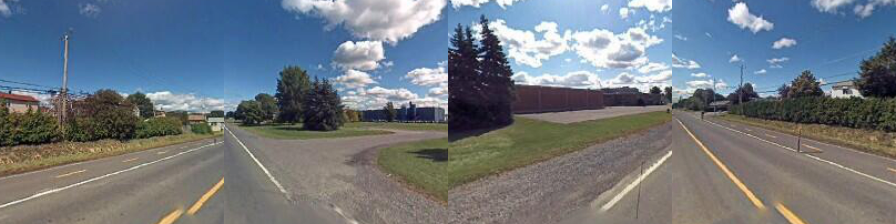

Actual province: Quebec
North prediction: Manitoba
East prediction: PEI
South prediction: NewBrunswick
West prediction: NovaScotia
Combined prediction: NewBrunswick


In [ ]:
with torch.no_grad():
  visualize_example(images, 10, True)
  smax = pretrained.forward(images[10])
  comb = smax.mean(axis=0)
  preds = smax.argmax(axis=1)
  comb_preds = comb.argmax()
  real_labels = dict((v, k) for k, v in dataset.labels.items())
  print(f"Actual province: {real_labels[labels[10].item()]}")
  print(f"North prediction: {real_labels[preds[0].item()]}")
  print(f"East prediction: {real_labels[preds[1].item()]}")
  print(f"South prediction: {real_labels[preds[2].item()]}")
  print(f"West prediction: {real_labels[preds[3].item()]}")
  print(f"Combined prediction: {real_labels[comb_preds.item()]}")

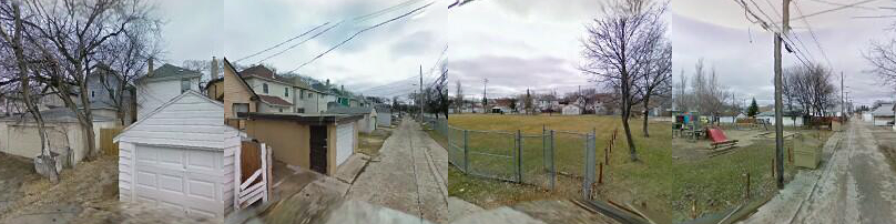

Actual province: Manitoba
North prediction: Alberta
East prediction: Alberta
South prediction: Alberta
West prediction: Alberta
Combined prediction: Alberta


In [ ]:
with torch.no_grad():
  visualize_example(images, 5, True)
  smax = pretrained.forward(images[5])
  comb = smax.mean(axis=0)
  preds = smax.argmax(axis=1)
  comb_preds = comb.argmax()
  real_labels = dict((v, k) for k, v in dataset.labels.items())
  print(f"Actual province: {real_labels[labels[5].item()]}")
  print(f"North prediction: {real_labels[preds[0].item()]}")
  print(f"East prediction: {real_labels[preds[1].item()]}")
  print(f"South prediction: {real_labels[preds[2].item()]}")
  print(f"West prediction: {real_labels[preds[3].item()]}")
  print(f"Combined prediction: {real_labels[comb_preds.item()]}")


In [ ]:
with torch.no_grad():
  visualize_example(images, 20, True)
  smax = pretrained.forward(images[20])
  comb = smax.mean(axis=0)
  preds = smax.argmax(axis=1)
  comb_preds = comb.argmax()
  real_labels = dict((v, k) for k, v in dataset.labels.items())
  print(f"Actual province: {real_labels[labels[20].item()]}")
  print(f"North prediction: {real_labels[preds[0].item()]}")
  print(f"East prediction: {real_labels[preds[1].item()]}")
  print(f"South prediction: {real_labels[preds[2].item()]}")
  print(f"West prediction: {real_labels[preds[3].item()]}")
  print(f"Combined prediction: {real_labels[comb_preds.item()]}")


In [ ]:
pretrained = torch.load("effnetb0crop.pt").cuda().eval()

In [13]:
pretrained = model
pred_counts = defaultdict(int)
pred_correct = defaultdict(int)
real_labels = dict((v, k) for k, v in dataset.labels.items())

for i, (inputs, labels) in enumerate(val_loader):
    inputs, labels = inputs.cuda(), labels.cuda()

    n_smax = pretrained.forward(inputs[:,0,...])
    e_smax = pretrained.forward(inputs[:,1,...])
    s_smax = pretrained.forward(inputs[:,2,...])
    w_smax = pretrained.forward(inputs[:,3,...])
    comb = (n_smax+e_smax+s_smax+w_smax)/4

    n_pred = n_smax.argmax(axis=1)
    e_pred = e_smax.argmax(axis=1)
    s_pred = s_smax.argmax(axis=1)
    w_pred = w_smax.argmax(axis=1)
    comb_pred = comb.argmax(axis=1)
    

    correct = comb_pred == labels
    for j, corr in enumerate(correct):
        pred_correct[real_labels[labels[j].item()]] += int(corr)
        pred_counts[real_labels[labels[j].item()]] += 1

print(pred_counts)
print(pred_correct)
for k, v in pred_counts.items():
    print(f"{k} accuracy: {pred_correct[k]/v:.4f}")
print(f"Overall accuracy: {sum(pred_correct.values())/sum(pred_counts.values())}")

defaultdict(<class 'int'>, {'Alberta': 398, 'Saskatchewan': 422, 'BritishColumbia': 420, 'NewfoundlandandLabrador': 413, 'Manitoba': 389, 'Ontario': 360, 'PEI': 397, 'Quebec': 369, 'NovaScotia': 413, 'NewBrunswick': 419})
defaultdict(<class 'int'>, {'Alberta': 265, 'Saskatchewan': 240, 'BritishColumbia': 325, 'NewfoundlandandLabrador': 282, 'Manitoba': 238, 'Ontario': 91, 'PEI': 342, 'Quebec': 129, 'NovaScotia': 227, 'NewBrunswick': 194})
Alberta accuracy: 0.6658
Saskatchewan accuracy: 0.5687
BritishColumbia accuracy: 0.7738
NewfoundlandandLabrador accuracy: 0.6828
Manitoba accuracy: 0.6118
Ontario accuracy: 0.2528
PEI accuracy: 0.8615
Quebec accuracy: 0.3496
NovaScotia accuracy: 0.5496
NewBrunswick accuracy: 0.4630
Overall accuracy: 0.58325
